## Apriori algorithm for ARM


In [1]:
#!pip install tensorflow==2.5.3

In [2]:
import time
start = time.time()

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from apyori import apriori
#from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.decomposition import NMF
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import seaborn as sns
import re

import warnings
warnings.simplefilter("ignore", UserWarning)


import warnings
warnings.simplefilter("ignore", UserWarning)

sns.set_style("whitegrid")

cols = ['1','2','3','4','5','6','7','8','9','10','11','12',
        '13','14','15','16','17','18','19','20','21','22',
        '23','24','25','26','27','28','29','30','31','32']

df = pd.read_csv("dataset/groceries-1.csv", sep = ",", 
                 names = cols, engine = "python")
data = np.array(df)
t=df.head(5)
t

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
0,citrus fruit,semi-finished bread,margarine,ready soups,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,tropical fruit,yogurt,coffee,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,whole milk,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,pip fruit,yogurt,cream cheese,meat spreads,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,other vegetables,whole milk,condensed milk,long life bakery product,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [3]:
df.describe()

,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
count,9835,7676,6033,4734,3729,2874,2229,1684,1246,896,...,14,8,7,7,6,5,4,1,1,1
unique,158,151,155,153,150,137,138,140,128,120,...,13,7,6,7,5,4,3,1,1,1
top,sausage,whole milk,whole milk,whole milk,rolls/buns,soda,soda,shopping bags,soda,shopping bags,...,waffles,bottled beer,chocolate,waffles,hygiene articles,napkins,house keeping products,skin care,hygiene articles,candles
freq,825,654,506,315,176,150,120,76,61,49,...,2,2,2,1,2,2,2,1,1,1


In [4]:
df.shape

(9835, 32)

In [5]:
df.dtypes

1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
13    object
14    object
15    object
16    object
17    object
18    object
19    object
20    object
21    object
22    object
23    object
24    object
25    object
26    object
27    object
28    object
29    object
30    object
31    object
32    object
dtype: object

In [6]:
df.isnull().sum()

1        0
2     2159
3     3802
4     5101
5     6106
6     6961
7     7606
8     8151
9     8589
10    8939
11    9185
12    9367
13    9484
14    9562
15    9639
16    9694
17    9740
18    9769
19    9783
20    9797
21    9806
22    9817
23    9821
24    9827
25    9828
26    9828
27    9829
28    9830
29    9831
30    9834
31    9834
32    9834
dtype: int64

In [7]:
# check corresponding values
correlation = df.corr()
correlation

""


In [8]:
def get_unique_items(data):
    ncol = data.shape[1]
    items = set()
    for c in range(ncol):
        items = items.union(data[:,c])
    items = np.array(list(items))
    items = items[items != np.array(None)]

    return np.unique(items)

In [9]:
def get_onehot_items(data,unique_items):
    onehot_items = np.zeros((len(data),len(unique_items)),dtype = np.int)
    for i, r in enumerate(data):
        for j, c in enumerate(unique_items):
            onehot_items[i,j] = int(c in r)
            
    return onehot_items

In [10]:
def get_items_from_ohe(ohe,unique_items):
    return unique_items[np.flatnonzero(ohe)]

unique_items = get_unique_items(data)
onehot_items = np.array(get_onehot_items(data, unique_items))


In [11]:

n = 15
item_counts = (onehot_items != 0).sum(0)
items_max_args = item_counts.argsort()[-n:][::-1]
ic = pd.DataFrame({"Items":unique_items[items_max_args], "Frequency":item_counts[items_max_args]})

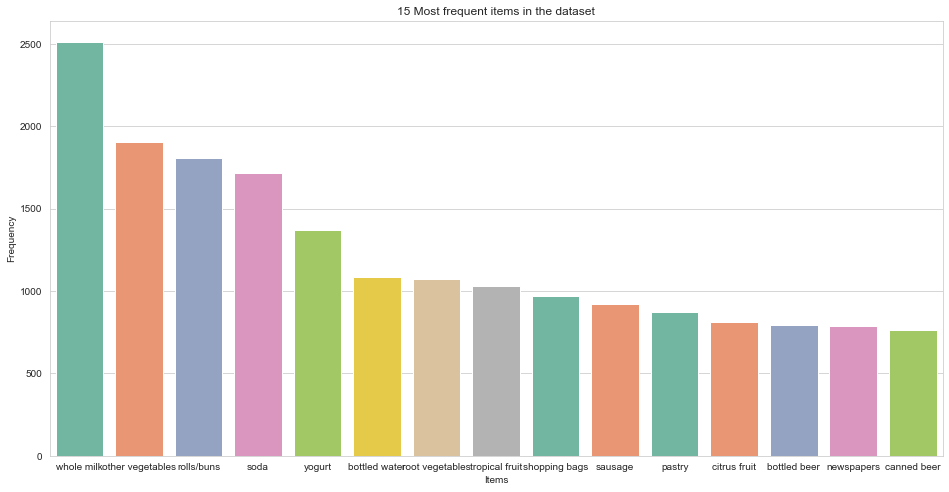

In [12]:

fig = plt.figure(figsize = (16,8))
sns.barplot(x="Items", y="Frequency", data=ic, palette=sns.color_palette("Set2", 10))
plt.xlabel("Items")
plt.ylabel("Frequency")
plt.title(str(n) + " Most frequent items in the dataset")
plt.show()

In [13]:
records = []
df = pd.read_csv("groceries.csv", sep = ",", names = cols, engine = "python")
for i in range(0, len(df)):
    records.append([str(df.values[i,j]) for j in range(0, 32)])

In [14]:
association_rules = apriori(records,min_support=0.002, min_confidence=0.2, min_lift=3, min_length=2)
association_results = list(association_rules)
result_apriory = pd.DataFrame()
for item in association_results:
    if len((list(item.ordered_statistics[0].items_base)))< 2:
       continue
    
    # first index of the inner list
    # Contains base item and add item
    pair = item[0] 
    items = [x for x in pair]
    item1=list(item.ordered_statistics[0].items_base)
    if 'nan' in item1: item1.remove('nan')
    if 'None' in item1: item1.remove('None')
    item2=list(item.ordered_statistics[0].items_add)
    if 'nan' in item2: item2.remove('nan')
    if 'None' in item2: item2.remove('None')
    
    print("Rule: " + str(item1) + " -> " + str(item2))

    #second index of the inner list
    print("Support: " + str(item[1]))
    #third index of the list located at 0th 
    #of the third index of the inner list

    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    #conviction
    sup=re.sub("[^\d\.]", "", str(item[1]))
    confd=re.sub("[^\d\.]", "", str(item[2][0][2]))
    Convicn=(1-float(sup))/(1-float(confd))
    print("Conviction: " + str(Convicn))
    print("=====================================")
    #print(str(item[2][0][4]))
        
    temp = pd.DataFrame({'item1':[ item1], 'item2': [item2], 'Support': (item[1]), 'Confidence': (item[2][0][2]), 'Lift': (item[2][0][3]), 'Conviction':(Convicn)})
    result_apriory = pd.concat([result_apriory, temp])

result_apriory.to_csv("result_apriory.csv", sep=',')    



Rule: ['soda', 'UHT-milk'] -> ['bottled water']
Support: 0.0028469750889679717
Confidence: 0.37333333333333335
Lift: 3.3778595522845754
Conviction: 1.5912016354963276
Rule: ['baking powder', 'rolls/buns'] -> ['other vegetables']
Support: 0.002135231316725979
Confidence: 0.6000000000000001
Lift: 3.1008933263268528
Conviction: 2.4946619217081856
Rule: ['other vegetables', 'baking powder'] -> ['root vegetables']
Support: 0.002541942043721403
Confidence: 0.3472222222222222
Lift: 3.185569548092869
Conviction: 1.5280208547415333
Rule: ['other vegetables', 'baking powder'] -> ['whipped/sour cream']
Support: 0.002440264361972547
Confidence: 0.33333333333333337
Lift: 4.6501182033096935
Conviction: 1.4963396034570413
Rule: ['baking powder', 'whole milk'] -> ['whipped/sour cream']
Support: 0.0026436197254702592
Confidence: 0.28571428571428575
Lift: 3.98581560283688
Conviction: 1.3962989323843418
Rule: ['bottled water', 'beef'] -> ['root vegetables']
Support: 0.002440264361972547
Confidence: 0.393

Rule: ['hard cheese', 'whole milk'] -> ['butter']
Support: 0.002135231316725979
Confidence: 0.21212121212121213
Lift: 3.8279121490130668
Conviction: 1.2665206679441556
Rule: ['hygiene articles', 'other vegetables'] -> ['butter']
Support: 0.002338586680223691
Confidence: 0.2446808510638298
Lift: 4.415479211399571
Conviction: 1.3208475049585773
Rule: ['hygiene articles', 'whole milk'] -> ['butter']
Support: 0.003050330452465684
Confidence: 0.2380952380952381
Lift: 4.296636085626911
Conviction: 1.3084964412811388
Rule: ['other vegetables', 'long life bakery product'] -> ['butter']
Support: 0.002440264361972547
Confidence: 0.22857142857142856
Lift: 4.124770642201835
Conviction: 1.2931329906418874
Rule: ['butter', 'napkins'] -> ['root vegetables']
Support: 0.0020335536349771225
Confidence: 0.40816326530612246
Lift: 3.744669509594883
Conviction: 1.6862191679960732
Rule: ['onions', 'butter'] -> ['root vegetables']
Support: 0.0020335536349771225
Confidence: 0.5
Lift: 4.5872201492537314
Convict

Rule: ['chocolate', 'pip fruit'] -> ['tropical fruit']
Support: 0.002135231316725979
Confidence: 0.35000000000000003
Lift: 3.335513565891473
Conviction: 1.535176567205037
Rule: ['waffles', 'rolls/buns'] -> ['chocolate']
Support: 0.0020335536349771225
Confidence: 0.2222222222222222
Lift: 4.478597449908925
Conviction: 1.2830997167550293
Rule: ['whipped/sour cream', 'chocolate'] -> ['yogurt']
Support: 0.0020335536349771225
Confidence: 0.4444444444444444
Lift: 3.1859410430838997
Conviction: 1.7963396034570411
Rule: ['citrus fruit', 'curd'] -> ['tropical fruit']
Support: 0.002338586680223691
Confidence: 0.32857142857142857
Lift: 3.131298449612403
Conviction: 1.4858787006890284
Rule: ['citrus fruit', 'curd'] -> ['yogurt']
Support: 0.003050330452465684
Confidence: 0.4285714285714286
Lift: 3.072157434402332
Conviction: 1.7446619217081851
Rule: ['citrus fruit', 'frozen vegetables'] -> ['root vegetables']
Support: 0.0026436197254702592
Confidence: 0.39999999999999997
Lift: 3.669776119402985
Conv

Rule: ['dessert', 'other vegetables'] -> ['fruit/vegetable juice']
Support: 0.0026436197254702592
Confidence: 0.22807017543859648
Lift: 3.1548103733313595
Conviction: 1.2920298562647319
Rule: ['dessert', 'yogurt'] -> ['fruit/vegetable juice']
Support: 0.002338586680223691
Confidence: 0.2371134020618557
Lift: 3.279901982107385
Conviction: 1.3077453661083556
Rule: ['dessert', 'other vegetables'] -> ['pip fruit']
Support: 0.0027452974072191155
Confidence: 0.2368421052631579
Lift: 3.1308361629881154
Conviction: 1.3067475413284717
Rule: ['dessert', 'root vegetables'] -> ['other vegetables']
Support: 0.0034570411794611084
Confidence: 0.5964912280701754
Lift: 3.0827594472255253
Conviction: 2.469693419685683
Rule: ['dessert', 'other vegetables'] -> ['whipped/sour cream']
Support: 0.0028469750889679717
Confidence: 0.2456140350877193
Lift: 3.4264028866492473
Conviction: 1.3218074981378798
Rule: ['dessert', 'pip fruit'] -> ['yogurt']
Support: 0.002135231316725979
Confidence: 0.4285714285714286
Li

Rule: ['grapes', 'other vegetables'] -> ['tropical fruit']
Support: 0.0036603965429588205
Confidence: 0.4044943820224719
Lift: 3.85484713875098
Conviction: 1.6730985793901259
Rule: ['grapes', 'yogurt'] -> ['other vegetables']
Support: 0.0028469750889679717
Confidence: 0.6086956521739131
Lift: 3.1458338093170966
Conviction: 2.5482799525504154
Rule: ['grapes', 'pip fruit'] -> ['tropical fruit']
Support: 0.002135231316725979
Confidence: 0.5675675675675675
Lift: 5.408940917661847
Conviction: 2.307562277580071
Rule: ['grapes', 'whole milk'] -> ['tropical fruit']
Support: 0.002541942043721403
Confidence: 0.3472222222222222
Lift: 3.3090412360034454
Conviction: 1.5280208547415333
Rule: ['ham', 'other vegetables'] -> ['pip fruit']
Support: 0.0026436197254702592
Confidence: 0.28888888888888886
Lift: 3.8188470728793305
Conviction: 1.4025324097610574
Rule: ['ham', 'root vegetables'] -> ['other vegetables']
Support: 0.002135231316725979
Confidence: 0.5833333333333334
Lift: 3.014757400595551
Convict

Rule: ['other vegetables', 'soft cheese'] -> ['root vegetables']
Support: 0.002440264361972547
Confidence: 0.3428571428571429
Lift: 3.1455223880597023
Conviction: 1.5180256846665638
Rule: ['other vegetables', 'tropical fruit'] -> ['root vegetables']
Support: 0.012302999491611592
Confidence: 0.34277620396600567
Lift: 3.144779819035136
Conviction: 1.5028320740494012
Rule: ['salty snack', 'other vegetables'] -> ['whipped/sour cream']
Support: 0.0027452974072191155
Confidence: 0.25471698113207547
Lift: 3.553392211963067
Conviction: 1.3380885882890479
Rule: ['other vegetables', 'semi-finished bread'] -> ['tropical fruit']
Support: 0.0022369089984748346
Confidence: 0.4313725490196078
Lift: 4.110997112023104
Conviction: 1.7546868152095787
Rule: ['other vegetables', 'semi-finished bread'] -> ['yogurt']
Support: 0.0022369089984748346
Confidence: 0.4313725490196078
Lift: 3.0922368947579026
Conviction: 1.7546868152095787
Rule: ['other vegetables', 'sliced cheese'] -> ['tropical fruit']
Support: 0

Rule: ['other vegetables', 'beef'] -> ['root vegetables']
Support: 0.007829181494661922
Confidence: 0.3969072164948454
Lift: 3.6448015632369786
Conviction: 1.6451379383763727
Rule: ['tropical fruit', 'beef'] -> ['other vegetables']
Support: 0.004372140315200813
Confidence: 0.581081081081081
Lift: 3.003117410631861
Conviction: 2.3766600521508106
Rule: ['pip fruit', 'beef'] -> ['root vegetables']
Support: 0.002338586680223691
Confidence: 0.47916666666666663
Lift: 4.400190631808278
Conviction: 1.9155099135739704
Rule: ['pork', 'beef'] -> ['root vegetables']
Support: 0.0027452974072191155
Confidence: 0.36000000000000004
Lift: 3.3058823529411767
Conviction: 1.5582104728012205
Rule: ['rolls/buns', 'beef'] -> ['root vegetables']
Support: 0.004880528723945094
Confidence: 0.35820895522388063
Lift: 3.289435177055897
Conviction: 1.5505349901278067
Rule: ['sausage', 'beef'] -> ['root vegetables']
Support: 0.0028469750889679717
Confidence: 0.5090909090909091
Lift: 4.674985145573381
Conviction: 2.03

Rule: ['butter', 'sausage'] -> ['whipped/sour cream']
Support: 0.002440264361972547
Confidence: 0.28235294117647064
Lift: 3.9445187165775413
Conviction: 1.3900422545775795
Rule: ['tropical fruit', 'butter'] -> ['whipped/sour cream']
Support: 0.0029486527707168276
Confidence: 0.29591836734693877
Lift: 4.134030032467533
Conviction: 1.4161019134560833
Rule: ['tropical fruit', 'butter'] -> ['yogurt']
Support: 0.004473817996949669
Confidence: 0.4489795918367347
Lift: 3.220798166093571
Conviction: 1.8066956636351656
Rule: ['butter', 'whole milk'] -> ['whipped/sour cream']
Support: 0.0066090493136756485
Confidence: 0.23985239852398524
Lift: 3.3507788913116405
Conviction: 1.3068395516310383
Rule: ['butter', 'yogurt'] -> ['whipped/sour cream']
Support: 0.0037620742247076767
Confidence: 0.2569444444444445
Lift: 3.5895576862373746
Conviction: 1.3407314141274962
Rule: ['other vegetables', 'butter milk'] -> ['fruit/vegetable juice']
Support: 0.002338586680223691
Confidence: 0.22549019607843138
Lift

Rule: ['cream cheese ', 'whole milk'] -> ['domestic eggs']
Support: 0.003355363497712252
Confidence: 0.2037037037037037
Lift: 3.2157719517270076
Conviction: 1.2516002411889195
Rule: ['fruit/vegetable juice', 'cream cheese '] -> ['yogurt']
Support: 0.002440264361972547
Confidence: 0.42857142857142855
Lift: 3.074398249452954
Conviction: 1.7457295373665482
Rule: ['root vegetables', 'cream cheese '] -> ['other vegetables']
Support: 0.004372140315200813
Confidence: 0.581081081081081
Lift: 3.0046963367152637
Conviction: 2.3766600521508106
Rule: ['other vegetables', 'cream cheese '] -> ['whipped/sour cream']
Support: 0.003253685815963396
Confidence: 0.23703703703703702
Lift: 3.3114478114478114
Conviction: 1.306415071988786
Rule: ['pastry', 'cream cheese '] -> ['yogurt']
Support: 0.002135231316725979
Confidence: 0.47727272727272735
Lift: 3.4237616868907903
Conviction: 1.9089586879158287
Rule: ['cream cheese ', 'whole milk'] -> ['pip fruit']
Support: 0.003965429588205389
Confidence: 0.240740740

Rule: ['root vegetables', 'domestic eggs'] -> ['whipped/sour cream']
Support: 0.003253685815963396
Confidence: 0.22695035460992907
Lift: 3.170535138620245
Conviction: 1.2893690853206345
Rule: ['soft cheese', 'whole milk'] -> ['domestic eggs']
Support: 0.0020335536349771225
Confidence: 0.2702702702702703
Lift: 4.266626176738536
Conviction: 1.3675836487224386
Rule: ['whole milk', 'sugar'] -> ['domestic eggs']
Support: 0.0034570411794611084
Confidence: 0.22972972972972974
Lift: 3.626632250227756
Conviction: 1.2937575254863136
Rule: ['domestic eggs', 'yogurt'] -> ['whipped/sour cream']
Support: 0.0034570411794611084
Confidence: 0.24113475177304966
Lift: 3.368693584784011
Conviction: 1.3132014690999625
Rule: ['other vegetables', 'flour'] -> ['root vegetables']
Support: 0.0022369089984748346
Confidence: 0.3548387096774193
Lift: 3.2584861901749944
Conviction: 1.5465327910523639
Rule: ['other vegetables', 'flour'] -> ['yogurt']
Support: 0.0026436197254702592
Confidence: 0.4193548387096774
Lift

Rule: ['grapes', 'pip fruit'] -> ['tropical fruit']
Support: 0.002135231316725979
Confidence: 0.5675675675675675
Lift: 5.4141872231105985
Conviction: 2.307562277580071
Rule: ['grapes', 'whole milk'] -> ['tropical fruit']
Support: 0.002541942043721403
Confidence: 0.3472222222222222
Lift: 3.3122507813341957
Conviction: 1.5280208547415333
Rule: ['ham', 'other vegetables'] -> ['pip fruit']
Support: 0.0026436197254702592
Confidence: 0.28888888888888886
Lift: 3.8188470728793305
Conviction: 1.4025324097610574
Rule: ['ham', 'other vegetables'] -> ['whipped/sour cream']
Support: 0.0020335536349771225
Confidence: 0.2222222222222222
Lift: 3.104482323232323
Conviction: 1.2830997167550293
Rule: ['ham', 'tropical fruit'] -> ['yogurt']
Support: 0.002338586680223691
Confidence: 0.4339622641509434
Lift: 3.1130699255467023
Conviction: 1.7625351635316049
Rule: ['ham', 'whole milk'] -> ['whipped/sour cream']
Support: 0.002541942043721403
Confidence: 0.22123893805309733
Lift: 3.0907456757843925
Conviction:

Rule: ['onions', 'pip fruit'] -> ['other vegetables']
Support: 0.002135231316725979
Confidence: 0.6176470588235294
Lift: 3.1937743551679345
Conviction: 2.609800164248563
Rule: ['onions', 'other vegetables'] -> ['root vegetables']
Support: 0.0056939501779359435
Confidence: 0.4
Lift: 3.673202614379085
Conviction: 1.6571767497034402
Rule: ['onions', 'tropical fruit'] -> ['other vegetables']
Support: 0.0036603965429588205
Confidence: 0.6428571428571428
Lift: 3.324132492113564
Conviction: 2.789750889679715
Rule: ['onions', 'other vegetables'] -> ['whipped/sour cream']
Support: 0.00315200813421454
Confidence: 0.22142857142857145
Lift: 3.0933948863636367
Conviction: 1.280355218910183
Rule: ['onions', 'rolls/buns'] -> ['root vegetables']
Support: 0.002541942043721403
Confidence: 0.3731343283582089
Lift: 3.4264949760998924
Conviction: 1.5911830924540635
Rule: ['onions', 'soda'] -> ['root vegetables']
Support: 0.002135231316725979
Confidence: 0.4038461538461539
Lift: 3.7085218702865768
Convictio

Rule: ['white bread', 'pip fruit'] -> ['tropical fruit']
Support: 0.002338586680223691
Confidence: 0.3538461538461538
Lift: 3.3754383347011863
Conviction: 1.5439998063282252
Rule: ['yogurt', 'pip fruit'] -> ['tropical fruit']
Support: 0.006405693950177936
Confidence: 0.3559322033898305
Lift: 3.395337750086308
Conviction: 1.5426858962352499
Rule: ['white bread', 'yogurt'] -> ['pip fruit']
Support: 0.002541942043721403
Confidence: 0.28089887640449435
Lift: 3.7132264105352175
Conviction: 1.38709011184545
Rule: ['shopping bags', 'pork'] -> ['root vegetables']
Support: 0.002135231316725979
Confidence: 0.33333333333333337
Lift: 3.061002178649238
Conviction: 1.4967971530249111
Rule: ['whole milk', 'processed cheese'] -> ['white bread']
Support: 0.002135231316725979
Confidence: 0.30434782608695654
Lift: 7.230098718756564
Conviction: 1.4344306049822064
Rule: ['shopping bags', 'rolls/buns'] -> ['sausage']
Support: 0.005998983223182512
Confidence: 0.3072916666666667
Lift: 3.2743375315998557
Convi

Rule: ['tropical fruit', 'beef'] -> ['root vegetables', 'whole milk']
Support: 0.002541942043721403
Confidence: 0.3333333333333333
Lift: 6.815661815661816
Conviction: 1.4961870869344178
Rule: ['yogurt', 'beef'] -> ['root vegetables', 'whole milk']
Support: 0.002541942043721403
Confidence: 0.21739130434782605
Lift: 4.444996836301184
Conviction: 1.2745297407219116
Rule: ['domestic eggs', 'bottled beer'] -> ['other vegetables', 'whole milk']
Support: 0.0020335536349771225
Confidence: 0.43478260869565216
Lift: 5.8099007561436675
Conviction: 1.7656329435688864
Rule: ['root vegetables', 'bottled beer'] -> ['other vegetables', 'whole milk']
Support: 0.002440264361972547
Confidence: 0.25263157894736843
Lift: 3.375858123569794
Conviction: 1.334763026557924
Rule: ['bottled beer', 'yogurt'] -> ['other vegetables', 'whole milk']
Support: 0.0026436197254702592
Confidence: 0.28571428571428575
Lift: 3.8179347826086962
Conviction: 1.3962989323843418
Rule: ['butter', 'bottled water'] -> ['other vegetab

Rule: ['other vegetables', 'butter', 'rolls/buns'] -> ['root vegetables']
Support: 0.002440264361972547
Confidence: 0.42857142857142855
Lift: 3.9319029850746268
Conviction: 1.7457295373665482
Rule: ['tropical fruit', 'butter'] -> ['root vegetables', 'other vegetables']
Support: 0.002338586680223691
Confidence: 0.23469387755102042
Lift: 4.953249540159412
Conviction: 1.3036109134045077
Rule: ['whipped/sour cream', 'butter'] -> ['root vegetables', 'other vegetables']
Support: 0.002135231316725979
Confidence: 0.21000000000000002
Lift: 4.432081545064378
Conviction: 1.2631199603585745
Rule: ['other vegetables', 'butter'] -> ['root vegetables', 'whole milk']
Support: 0.004168784951703101
Confidence: 0.2081218274111675
Lift: 4.255463976276159
Conviction: 1.2575560856699646
Rule: ['other vegetables', 'butter', 'yogurt'] -> ['root vegetables']
Support: 0.002135231316725979
Confidence: 0.33333333333333337
Lift: 3.0581467661691546
Conviction: 1.4967971530249111
Rule: ['butter', 'sausage'] -> ['oth

Confidence: 0.3108108108108108
Lift: 5.5477755432383375
Conviction: 1.4475871487384988
Rule: ['whipped/sour cream', 'cream cheese '] -> ['whole milk', 'yogurt']
Support: 0.002338586680223691
Confidence: 0.36507936507936506
Lift: 6.516434765073603
Conviction: 1.5713167259786478
Rule: ['domestic eggs', 'curd'] -> ['other vegetables', 'whole milk']
Support: 0.0028469750889679717
Confidence: 0.43750000000000006
Lift: 5.846212635869566
Conviction: 1.7727164887307236
Rule: ['domestic eggs', 'curd'] -> ['whole milk', 'yogurt']
Support: 0.0020335536349771225
Confidence: 0.3125
Lift: 5.5779264972776765
Conviction: 1.4515875583491242
Rule: ['curd', 'pip fruit'] -> ['other vegetables', 'whole milk']
Support: 0.0022369089984748346
Confidence: 0.2857142857142857
Lift: 3.8179347826086953
Conviction: 1.3968683274021352
Rule: ['curd', 'rolls/buns'] -> ['other vegetables', 'whole milk']
Support: 0.002440264361972547
Confidence: 0.24242424242424243
Lift: 3.239459815546772
Conviction: 1.3167788510421963


Rule: ['root vegetables', 'frankfurter'] -> ['whole milk', 'yogurt']
Support: 0.002338586680223691
Confidence: 0.23
Lift: 4.10535390199637
Conviction: 1.2956641731425667
Rule: ['tropical fruit', 'frankfurter'] -> ['whole milk', 'yogurt']
Support: 0.002135231316725979
Confidence: 0.22580645161290322
Lift: 4.03050172706516
Conviction: 1.288908659549229
Rule: ['fruit/vegetable juice', 'frozen vegetables'] -> ['other vegetables', 'whole milk']
Support: 0.0022369089984748346
Confidence: 0.2857142857142857
Lift: 3.8179347826086953
Conviction: 1.3968683274021352
Rule: ['fruit/vegetable juice', 'frozen vegetables'] -> ['whole milk', 'yogurt']
Support: 0.002135231316725979
Confidence: 0.27272727272727276
Lift: 4.8680085794423364
Conviction: 1.3720640569395017
Rule: ['other vegetables', 'frozen vegetables'] -> ['root vegetables', 'whole milk']
Support: 0.003863751906456533
Confidence: 0.21714285714285714
Lift: 4.43991683991684
Conviction: 1.2724368132581758
Rule: ['tropical fruit', 'frozen veget

Rule: ['pork', 'rolls/buns'] -> ['other vegetables', 'whole milk']
Support: 0.003253685815963396
Confidence: 0.2882882882882883
Lift: 3.852330591461026
Conviction: 1.4004916566383299
Rule: ['root vegetables', 'pork'] -> ['other vegetables', 'whole milk']
Support: 0.0037620742247076767
Confidence: 0.27611940298507465
Lift: 3.6897205548345235
Conviction: 1.3762462067411256
Rule: ['whipped/sour cream', 'pork'] -> ['other vegetables', 'whole milk']
Support: 0.002440264361972547
Confidence: 0.2962962962962963
Lift: 3.9593397745571655
Conviction: 1.4175848874856178
Rule: ['pork', 'yogurt'] -> ['other vegetables', 'whole milk']
Support: 0.002338586680223691
Confidence: 0.2446808510638298
Lift: 3.269614361702128
Conviction: 1.3208475049585773
Rule: ['other vegetables', 'tropical fruit', 'rolls/buns'] -> ['root vegetables']
Support: 0.0035587188612099642
Confidence: 0.45454545454545453
Lift: 4.17020013568521
Conviction: 1.8268090154211152
Rule: ['whipped/sour cream', 'other vegetables', 'rolls/

Rule: ['pastry', 'pip fruit'] -> ['whole milk', 'yogurt']
Support: 0.002135231316725979
Confidence: 0.2
Lift: 3.5698729582577133
Conviction: 1.2473309608540923
Rule: ['pastry', 'root vegetables'] -> ['whole milk', 'rolls/buns']
Support: 0.0022369089984748346
Confidence: 0.2037037037037037
Lift: 3.5968149478023803
Conviction: 1.2530048119554038
Rule: ['pastry', 'tropical fruit', 'rolls/buns'] -> ['yogurt']
Support: 0.002135231316725979
Confidence: 0.525
Lift: 3.763392857142857
Conviction: 2.1007679340700505
Rule: ['pastry', 'root vegetables'] -> ['whole milk', 'yogurt']
Support: 0.002541942043721403
Confidence: 0.23148148148148145
Lift: 4.131797405390871
Conviction: 1.297897232039495
Rule: ['whole milk', 'sausage', 'yogurt'] -> ['pastry']
Support: 0.002338586680223691
Confidence: 0.26744186046511625
Lift: 3.0060465116279067
Conviction: 1.3618870086587422
Rule: ['pastry', 'tropical fruit'] -> ['whole milk', 'yogurt']
Support: 0.003050330452465684
Confidence: 0.23076923076923075
Lift: 4.1

Rule: ['whole milk', 'bottled water', 'rolls/buns'] -> ['tropical fruit']
Support: 0.0028469750889679717
Confidence: 0.32558139534883723
Lift: 3.1058128256603434
Conviction: 1.4785372438335993
Rule: ['tropical fruit', 'bottled water', 'rolls/buns'] -> ['yogurt']
Support: 0.002440264361972547
Confidence: 0.45283018867924535
Lift: 3.24842079187482
Conviction: 1.8231264134074299
Rule: ['whole milk', 'root vegetables', 'bottled water'] -> ['tropical fruit']
Support: 0.002541942043721403
Confidence: 0.3472222222222222
Lift: 3.3122507813341957
Conviction: 1.5280208547415333
Rule: ['root vegetables', 'tropical fruit', 'bottled water'] -> ['yogurt']
Support: 0.0022369089984748346
Confidence: 0.4888888888888888
Lift: 3.507091336412999
Conviction: 1.952145178046462
Rule: ['soda', 'sausage', 'bottled water'] -> ['yogurt']
Support: 0.0020335536349771225
Confidence: 0.5
Lift: 3.5867979576951132
Conviction: 1.9959328927300457
Rule: ['soda', 'tropical fruit', 'bottled water'] -> ['yogurt']
Support: 0

Rule: ['whipped/sour cream', 'butter'] -> ['whole milk', 'yogurt']
Support: 0.002541942043721403
Confidence: 0.25
Lift: 4.470454545454546
Conviction: 1.3299440772750382
Rule: ['other vegetables', 'butter milk'] -> ['whole milk', 'yogurt']
Support: 0.0022369089984748346
Confidence: 0.2156862745098039
Lift: 3.856862745098039
Conviction: 1.2721479410269445
Rule: ['domestic eggs', 'chicken'] -> ['other vegetables', 'whole milk']
Support: 0.002338586680223691
Confidence: 0.3770491803278689
Lift: 5.045277127244341
Conviction: 1.6015091108554302
Rule: ['rolls/buns', 'chicken'] -> ['other vegetables', 'whole milk']
Support: 0.0027452974072191155
Confidence: 0.28421052631578947
Lift: 3.8030075187969925
Conviction: 1.3932234815634439
Rule: ['root vegetables', 'chicken'] -> ['other vegetables', 'whole milk']
Support: 0.0028469750889679717
Confidence: 0.26168224299065423
Lift: 3.5015576323987543
Conviction: 1.3505743501959548
Rule: ['whipped/sour cream', 'chicken'] -> ['other vegetables', 'whole m

Rule: ['root vegetables', 'curd'] -> ['other vegetables', 'yogurt']
Support: 0.002338586680223691
Confidence: 0.21495327102803738
Lift: 4.9625948839454175
Conviction: 1.2708306098240008
Rule: ['tropical fruit', 'curd'] -> ['other vegetables', 'whole milk']
Support: 0.003050330452465684
Confidence: 0.297029702970297
Lift: 3.9745403111739748
Conviction: 1.4181960087929715
Rule: ['tropical fruit', 'curd'] -> ['other vegetables', 'yogurt']
Support: 0.002440264361972547
Confidence: 0.23762376237623764
Lift: 5.485985218240135
Conviction: 1.3084874454472828
Rule: ['whipped/sour cream', 'curd'] -> ['other vegetables', 'whole milk']
Support: 0.002440264361972547
Confidence: 0.2330097087378641
Lift: 3.117891816920944
Conviction: 1.3006158578571752
Rule: ['other vegetables', 'curd'] -> ['whole milk', 'yogurt']
Support: 0.0035587188612099642
Confidence: 0.20710059171597633
Lift: 3.7033351264120498
Conviction: 1.256705794869071
Rule: ['pastry', 'curd'] -> ['whole milk', 'yogurt']
Support: 0.0023385

Rule: ['frozen vegetables', 'yogurt'] -> ['other vegetables', 'whole milk']
Support: 0.0035587188612099642
Confidence: 0.28688524590163933
Lift: 3.83879781420765
Conviction: 1.3973084632061195
Rule: ['root vegetables', 'frozen vegetables'] -> ['tropical fruit', 'whole milk']
Support: 0.002338586680223691
Confidence: 0.20175438596491227
Lift: 4.781335869794969
Conviction: 1.2498175947082912
Rule: ['fruit/vegetable juice', 'pip fruit'] -> ['other vegetables', 'whole milk']
Support: 0.002440264361972547
Confidence: 0.25531914893617025
Lift: 3.416413373860183
Conviction: 1.3395802164282085
Rule: ['fruit/vegetable juice', 'pip fruit'] -> ['other vegetables', 'yogurt']
Support: 0.0022369089984748346
Confidence: 0.23404255319148937
Lift: 5.403306363000699
Conviction: 1.3026351465853245
Rule: ['root vegetables', 'fruit/vegetable juice'] -> ['other vegetables', 'tropical fruit']
Support: 0.002541942043721403
Confidence: 0.21186440677966098
Lift: 5.91956375192604
Conviction: 1.2655919445036654
R

Rule: ['whipped/sour cream', 'rolls/buns'] -> ['other vegetables', 'whole milk']
Support: 0.0036603965429588205
Confidence: 0.25
Lift: 3.3452380952380953
Conviction: 1.3284528046093882
Rule: ['root vegetables', 'sausage'] -> ['other vegetables', 'whole milk']
Support: 0.003355363497712252
Confidence: 0.22448979591836735
Lift: 3.0038872691933918
Conviction: 1.2851470312792659
Rule: ['root vegetables', 'shopping bags'] -> ['other vegetables', 'whole milk']
Support: 0.0029486527707168276
Confidence: 0.23015873015873015
Lift: 3.079743008314437
Conviction: 1.2951388634112337
Rule: ['other vegetables', 'shopping bags', 'yogurt'] -> ['root vegetables']
Support: 0.002135231316725979
Confidence: 0.3962264150943397
Lift: 3.6385497595264527
Conviction: 1.652713523131673
Rule: ['other vegetables', 'sliced cheese'] -> ['root vegetables', 'whole milk']
Support: 0.002440264361972547
Confidence: 0.2696629213483146
Lift: 5.525280898876404
Conviction: 1.3658894841812992
Rule: ['root vegetables', 'soda',

Rule: ['citrus fruit', 'other vegetables', 'tropical fruit'] -> ['whole milk', 'yogurt']
Support: 0.002440264361972547
Confidence: 0.2696629213483146
Lift: 4.8133118538306245
Conviction: 1.3658894841812992
Rule: ['other vegetables', 'root vegetables', 'fruit/vegetable juice'] -> ['whole milk', 'yogurt']
Support: 0.0020335536349771225
Confidence: 0.3076923076923077
Lift: 5.492112243473405
Conviction: 1.441507089193922
Rule: ['root vegetables', 'other vegetables', 'pip fruit'] -> ['tropical fruit', 'whole milk']
Support: 0.002440264361972547
Confidence: 0.3
Lift: 7.092548076923077
Conviction: 1.4250853366257537
Rule: ['root vegetables', 'other vegetables', 'pip fruit'] -> ['whole milk', 'yogurt']
Support: 0.002338586680223691
Confidence: 0.2875
Lift: 5.131692377495463
Conviction: 1.4002265450102123
Rule: ['other vegetables', 'tropical fruit', 'pip fruit'] -> ['whole milk', 'yogurt']
Support: 0.002338586680223691
Confidence: 0.24731182795698922
Lift: 4.414359034404699
Conviction: 1.325464

In [15]:
end = time.time() 
print("Time consumed in working of Apriori Algorithm: ",end - start)

Time consumed in working of Apriori Algorithm:  227.57701206207275


### now using the set of rules generated by the algorithm

In [16]:
ndf = pd.read_csv("result_apriory.csv", engine = "python")
ndf = ndf.drop('Unnamed: 0', 1)
new_data = np.array(ndf)
re=ndf.head(5)
re

,item1,item2,Support,Confidence,Lift,Conviction
0,"['soda', 'UHT-milk']",['bottled water'],0.002847,0.373333,3.377860,1.591202
1,"['baking powder', 'rolls/buns']",['other vegetables'],0.002135,0.600000,3.100893,2.494662
2,"['other vegetables', 'baking powder']",['root vegetables'],0.002542,0.347222,3.185570,1.528021
3,"['other vegetables', 'baking powder']",['whipped/sour cream'],0.002440,0.333333,4.650118,1.496340
4,"['baking powder', 'whole milk']",['whipped/sour cream'],0.002644,0.285714,3.985816,1.396299


In [17]:
ndf

,item1,item2,Support,Confidence,Lift,Conviction
0,"['soda', 'UHT-milk']",['bottled water'],0.002847,0.373333,3.377860,1.591202
1,"['baking powder', 'rolls/buns']",['other vegetables'],0.002135,0.600000,3.100893,2.494662
2,"['other vegetables', 'baking powder']",['root vegetables'],0.002542,0.347222,3.185570,1.528021
3,"['other vegetables', 'baking powder']",['whipped/sour cream'],0.002440,0.333333,4.650118,1.496340
4,"['baking powder', 'whole milk']",['whipped/sour cream'],0.002644,0.285714,3.985816,1.396299
5,"['bottled water', 'beef']",['root vegetables'],0.002440,0.393443,3.609616,1.644626
6,"['butter', 'beef']",['root vegetables'],0.002949,0.508772,4.667698,2.029712
7,"['butter', 'beef']",['yogurt'],0.002745,0.473684,3.395542,1.894784
8,"['citrus fruit', 'beef']",['root vegetables'],0.003864,0.457831,4.200346,1.837318
9,"['tropical fruit', 'beef']",['citrus fruit'],0.002034,0.266667,3.221949,1.360863


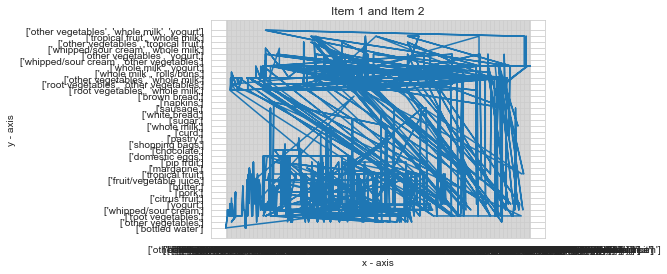

In [18]:
plt.plot(ndf.item1, ndf.item2)
 
# naming the x axis
plt.xlabel('x - axis')
# naming the y axis
plt.ylabel('y - axis')
 
# giving a title to my graph
plt.title('Item 1 and Item 2')
 
# function to show the plot
plt.show()